# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
silver = pd.read_csv('Acuity.csv')
intake = pd.read_csv('acuity_intake_source_2021.csv')

## Acuity

In [3]:
intake.shape

(1637, 18)

In [4]:
intake.head()

,Start Time,End Time,First Name,Last Name,Phone,Email,Type,Calendar,Appointment Price,Paid?,Amount Paid Online,Certificate Code,Notes,Date Scheduled,Label,Scheduled By,Campaign,Appointment ID
0,"January 1, 2021 12:00 pm","January 1, 2021 12:20 pm",Juan,Sanchez,9419628012,Juanmartinsanchezjr1@yahoo.com,Hair Consultation,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,Attempted to reach x2. No answer. Left VM. Sen...,2020-12-28,No Show,a client,NaN,496882242
1,"January 1, 2021 12:30 pm","January 1, 2021 1:00 pm",Belinda,maldonado,9729047336,belinda1510@aol.com,Hair Mineral Analysis Appointment,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,NaN,2020-12-28,Completed,a client,NaN,496924802
2,"January 1, 2021 1:05 pm","January 1, 2021 1:35 pm",Olya,Caldwell,5129470632,olya.caldwell@gmail.com,Hair Mineral Analysis Appointment,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,NaN,2020-12-28,No Show,a client,NaN,496928884
3,"January 1, 2021 2:00 pm","January 1, 2021 2:20 pm",Jennifer,Reason,2147040570,jlreason@gmail.com,Hair Consultation,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,No answer. Left VM. Sent email with link to re...,2020-12-30,No Show,a client,NaN,498606565
4,"January 1, 2021 2:25 pm","January 1, 2021 2:55 pm",Caren,Levin,3107806618,carenlevin@mac.com,Hair Mineral Analysis Appointment,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,NaN,2020-12-28,Completed,a client,NaN,496942275


<AxesSubplot:>

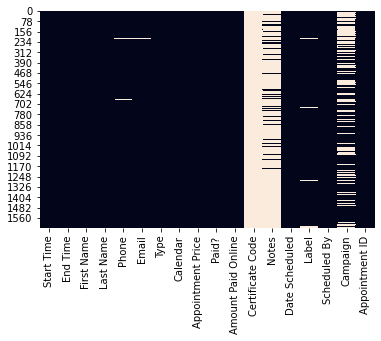

In [19]:
# Check for null values
sns.heatmap(intake.isnull(), cbar=False)

In [ ]:
silver.APPOINTMENT_BODY_ID

In [9]:
intake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637 entries, 0 to 1636
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Start Time          1637 non-null   object 
 1   End Time            1637 non-null   object 
 2   First Name          1637 non-null   object 
 3   Last Name           1637 non-null   object 
 4   Phone               1625 non-null   object 
 5   Email               1630 non-null   object 
 6   Type                1637 non-null   object 
 7   Calendar            1637 non-null   object 
 8   Appointment Price   1637 non-null   float64
 9   Paid?               1637 non-null   object 
 10  Amount Paid Online  1637 non-null   float64
 11  Certificate Code    0 non-null      float64
 12  Notes               232 non-null    object 
 13  Date Scheduled      1637 non-null   object 
 14  Label               1590 non-null   object 
 15  Scheduled By        1637 non-null   object 
 16  Campai

In [18]:
intake.loc[intake['Appointment ID'] == 496882242]

,Start Time,End Time,First Name,Last Name,Phone,Email,Type,Calendar,Appointment Price,Paid?,Amount Paid Online,Certificate Code,Notes,Date Scheduled,Label,Scheduled By,Campaign,Appointment ID
0,"January 1, 2021 12:00 pm","January 1, 2021 12:20 pm",Juan,Sanchez,9419628012,Juanmartinsanchezjr1@yahoo.com,Hair Consultation,"Dr. Ariana Zastrow, ND",0.0,no,0.0,NaN,Attempted to reach x2. No answer. Left VM. Sen...,2020-12-28,No Show,a client,NaN,496882242


In [21]:
# Change dates to datetime Dtype
intake['Start Time'] = pd.to_datetime(intake['Start Time'])

In [22]:
min(intake['Start Time'])

Timestamp('2021-01-01 12:00:00')

In [4]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

silver_acuity['EVENT'].value_counts()

appointment_changed        18189
appointment_scheduled       5220
appointment_rescheduled      705
appointment_canceled         431
Name: EVENT, dtype: int64

In [5]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    5105
Name: EVENT, dtype: int64

In [6]:
silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    5104
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [7]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      4297
Hair Mineral Analysis Appointment       599
Follow Up Consultation                  143
Customer consultation                    58
Case Study                                5
Hair Mineral Analysis - Acquisition       3
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [8]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis - Acquisition':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    4297
Hair Mineral Analysis Appointment     599
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [9]:
silver_acuity.shape

(4896, 8)

In [10]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     4241
False     655
Name: Complete, dtype: int64

In [11]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    4241
Name: Complete, dtype: int64

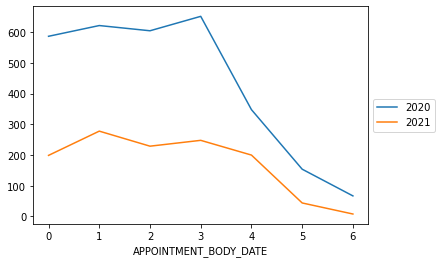

In [13]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.year])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [14]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-01-26 00:00:00')

In [15]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    3724
Hair Mineral Analysis Appointment     517
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [16]:
#QA instances
smail = silver_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  3665


In [17]:
clean_acuity = silver_acuity.groupby('EMAIL').agg({"APPOINTMENT_BODY_DATE":'min',\
                                'APPOINTMENT_BODY_TYPE':'last',\
                                'APPOINTMENT_BODY_CALENDAR':'last'\
                               })
clean_acuity.shape

(3665, 3)

## SUB

In [4]:
sub_2019=pd.merge(sub_20191,sub_20192,how='outer')
print('total',sub_2019.shape)
print('1',sub_20191.shape)
print('2',sub_20192.shape)

# Change dates to datetime 
sub_2018['FIRST_ORDER_AT'] = pd.to_datetime(sub_2018['FIRST_ORDER_AT'])
sub_2019['FIRST_ORDER_AT'] = pd.to_datetime(sub_2019['FIRST_ORDER_AT'])
sub_2020['FIRST_ORDER_AT'] = pd.to_datetime(sub_2020['FIRST_ORDER_AT'])
sub_2021['FIRST_ORDER_AT'] = pd.to_datetime(sub_2021['FIRST_ORDER_AT'])

total (1373086, 7)
1 (731229, 7)
2 (641857, 7)


In [5]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

s18 = sub_2018.shape
email18 = sub_2018['EMAIL'].nunique()
print ('2018 = ',s18)
print ('2018 unique emails = ',email18)

s19 = sub_2019.shape
email19 = sub_2019['EMAIL'].nunique()
print ('2019 = ',s19)
print ('2019 unique emails = ',email19)

s20 = sub_2020.shape
email20 = sub_2020['EMAIL'].nunique()
print ('2020 = ',s20)
print ('2020 unique emails = ',email20)

s21 = sub_2021.shape
email21 = sub_2021['EMAIL'].nunique()
print ('2021 = ',s21)
print ('2021 unique emails = ',email21)

2018 =  (614903, 7)
2018 unique emails =  18970
2019 =  (1373086, 7)
2019 unique emails =  57184
2020 =  (727153, 7)
2020 unique emails =  82292
2021 =  (29623, 7)
2021 unique emails =  15563


In [6]:
# Aggregate
df18 = sub_2018.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df18.shape

(18970, 6)

In [7]:
# Aggregate
df19 = sub_2019.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df19.shape

(57184, 6)

In [8]:
# Aggregate
df20 = sub_2020.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df20.shape

(82292, 6)

In [9]:
# Aggregate
df21 = sub_2021.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df21.shape

(15563, 6)

In [10]:
df18.describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,18970.000000,18970.000000
mean,1128.418274,13.886821
std,699.363207,8.466934
min,0.000000,1.000000
25%,569.000000,7.000000
50%,959.000000,12.000000
75%,1616.150000,20.000000
max,7926.000000,94.000000


In [11]:
df19.describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,57164.000000,57164.000000
mean,600.802524,7.187163
std,507.358073,5.830056
min,-32.000000,1.000000
25%,198.000000,3.000000
50%,434.000000,5.000000
75%,891.000000,11.000000
max,5688.000000,54.000000


In [12]:
df20.describe() 

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,82277.000000,82277.000000
mean,368.919930,4.458694
std,259.610407,2.859405
min,-32.000000,1.000000
25%,168.000000,2.000000
50%,306.000000,4.000000
75%,495.000000,6.000000
max,3777.000000,61.000000


In [13]:
df21.describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,15561.000000,15561.000000
mean,99.385860,1.190862
std,55.743408,0.409648
min,0.000000,1.000000
25%,79.000000,1.000000
50%,79.000000,1.000000
75%,99.000000,1.000000
max,1864.400000,6.000000


In [14]:
sub1=pd.merge(sub_2019,sub_2018,how='outer')
sub2=pd.merge(sub_2020,sub_2021,how='outer')
sub3=pd.merge(sub1,sub2,how='outer')

In [15]:
sub3 = sub3.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
sub3.shape

(174009, 6)

In [19]:
df20.ITEM_SUB_TYPE.value_counts()

GrowthPlan                                             47413
GrowthPlan 3                                           23282
GrowthPlan 2                                           10325
GrowthPlan,GrowthPlan                                    713
GrowthPlan,GrowthPlan 3                                   85
GrowthPlan 3,GrowthPlan                                   80
GrowthPlan 3,GrowthPlan 3                                 76
GrowthPlan,GrowthPlan 2                                   42
Non-Sub,GrowthPlan                                        39
GrowthPlan,Non-Sub                                        38
GrowthPlan 2,GrowthPlan                                   37
GrowthPlan 2,GrowthPlan 2                                 31
GrowthPlan 2,GrowthPlan 3                                 20
GrowthPlan 3,Non-Sub                                      18
Non-Sub,GrowthPlan 3                                      17
GrowthPlan 3,GrowthPlan 2                                 17
GrowthPlan,GrowthPlan,Gr

In [16]:
sub3.ITEM_SUB_TYPE.value_counts()

GrowthPlan                                             108509
GrowthPlan 3                                            49039
GrowthPlan 2                                            13219
GrowthPlan,GrowthPlan                                    1269
GrowthPlan 3,GrowthPlan                                   165
GrowthPlan,GrowthPlan 3                                   159
GrowthPlan 3,GrowthPlan 3                                 123
Non-Sub,GrowthPlan                                         70
GrowthPlan,Non-Sub                                         62
GrowthPlan,GrowthPlan 2                                    54
Prepay 6                                                   51
GrowthPlan 2,GrowthPlan                                    50
Non-Sub,GrowthPlan 3                                       49
GrowthPlan 3,Non-Sub                                       42
GrowthPlan 2,GrowthPlan 2                                  37
GrowthPlan,GrowthPlan,GrowthPlan                           26
GrowthPl

In [30]:
sub3.describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,173972.000000,173972.000000
mean,503.819802,6.090974
std,488.803856,5.770287
min,-32.000000,1.000000
25%,158.000000,2.000000
50%,338.200000,4.000000
75%,681.000000,8.000000
max,7926.000000,94.000000


## Merge

In [31]:
sub = pd.merge(clean_acuity,sub3, how='left',on='EMAIL',copy=False)
sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3665 entries, 101akpatel@gmail.com to zusette1950@yahoo.com
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   APPOINTMENT_BODY_DATE       3665 non-null   datetime64[ns]
 1   APPOINTMENT_BODY_TYPE       3665 non-null   object        
 2   APPOINTMENT_BODY_CALENDAR   3665 non-null   object        
 3   FIRST_ORDER_AT              2945 non-null   datetime64[ns]
 4   TOTAL_ORDER_VALUE           2945 non-null   float64       
 5   TOTAL_ORDERS                2945 non-null   float64       
 6   ITEM_GENDER                 2945 non-null   object        
 7   ITEM_SUB_TYPE               2945 non-null   object        
 8   ITEM_PRODUCT_CORE_CATEGORY  2945 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 286.3+ KB


In [32]:
# clean up item sub
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan']= 'GrowthPlan 2'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2']= 'GrowthPlan 2'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub']= 'GrowthPlan 3'

sub['ITEM_SUB_TYPE'].value_counts()

GrowthPlan      1372
GrowthPlan 3    1027
GrowthPlan 2     546
Name: ITEM_SUB_TYPE, dtype: int64

In [33]:
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Men']= 'Men'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan 2']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan 3']= 'Balance'

sub['ITEM_PRODUCT_CORE_CATEGORY'].value_counts()

Women      1452
Balance    1006
Men         487
Name: ITEM_PRODUCT_CORE_CATEGORY, dtype: int64

In [34]:
# Export data
sub.to_csv('sub.csv')
sub.describe()

,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_CALENDAR,FIRST_ORDER_AT,TOTAL_ORDER_VALUE,TOTAL_ORDERS,ITEM_GENDER,ITEM_SUB_TYPE,ITEM_PRODUCT_CORE_CATEGORY
count,3665,3665,3665,2945,2945.0,2945.0,2945,2945,2945
unique,119,4,11,2922,807.0,36.0,3,5,3
top,2020-11-12 00:00:00,Hair Consultation,"Dr. Ariana Zastrow, ND",Balance,158.0,2.0,Women,GrowthPlan,Women
freq,76,3224,709,24,100.0,462.0,2434,1359,1452
